<a href="https://colab.research.google.com/github/neochoon/2024_UTS/blob/main/Week2_WordEmbeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Word embeddings

This tutorial contains an introduction to word embeddings. You will train your own word embeddings using a simple Keras model for a sentiment classification task, and then visualize them in the [Embedding Projector](http://projector.tensorflow.org) (shown in the image below).

<img src="https://github.com/tensorflow/text/blob/master/docs/guide/images/embedding.jpg?raw=1" alt="Screenshot of the embedding projector" width="400"/>

## Representing text as numbers

Machine learning models take vectors (arrays of numbers) as input. When working with text, the first thing you must do is come up with a strategy to convert strings to numbers (or to "vectorize" the text) before feeding it to the model. In this section, you will look at three strategies for doing so.

### One-hot encodings

As a first idea, you might "one-hot" encode each word in your vocabulary. Consider the sentence "The cat sat on the mat". The vocabulary (or unique words) in this sentence is (cat, mat, on, sat, the). To represent each word, you will create a zero vector with length equal to the vocabulary, then place a one in the index that corresponds to the word. This approach is shown in the following diagram.

<img src="https://github.com/tensorflow/text/blob/master/docs/guide/images/one-hot.png?raw=1" alt="Diagram of one-hot encodings" width="400" />

To create a vector that contains the encoding of the sentence, you could then concatenate the one-hot vectors for each word.

Key point: This approach is inefficient. A one-hot encoded vector is sparse (meaning, most indices are zero). Imagine you have 10,000 words in the vocabulary. To one-hot encode each word, you would create a vector where 99.99% of the elements are zero.

### Encode each word with a unique number

A second approach you might try is to encode each word using a unique number. Continuing the example above, you could assign 1 to "cat", 2 to "mat", and so on. You could then encode the sentence "The cat sat on the mat" as a dense vector like [5, 1, 4, 3, 5, 2]. This approach is efficient. Instead of a sparse vector, you now have a dense one (where all elements are full).

There are two downsides to this approach, however:

* The integer-encoding is arbitrary (it does not capture any relationship between words).

* An integer-encoding can be challenging for a model to interpret. A linear classifier, for example, learns a single weight for each feature. Because there is no relationship between the similarity of any two words and the similarity of their encodings, this feature-weight combination is not meaningful.

### Word embeddings

Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

<img src="https://github.com/tensorflow/text/blob/master/docs/guide/images/embedding2.png?raw=1" alt="Diagram of an embedding" width="400"/>

Above is a diagram for a word embedding. Each word is represented as a 4-dimensional vector of floating point values. Another way to think of an embedding is as "lookup table". After these weights have been learned, you can encode each word by looking up the dense vector it corresponds to in the table.

## Setup

In [ ]:
import io
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization

### Download the IMDb Dataset
You will use the [Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/) through the tutorial. You will train a sentiment classifier model on this dataset and in the process learn embeddings from scratch. To read more about loading a dataset from scratch, see the [Loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text).  

Download the dataset using Keras file utility and take a look at the directories.

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
os.listdir(dataset_dir)

84125825/84125825 [==============================] - 3s 0us/step


['test', 'imdb.vocab', 'README', 'train', 'imdbEr.txt']

Take a look at the `train/` directory. It has `pos` and `neg` folders with movie reviews labelled as positive and negative respectively. You will use reviews from `pos` and `neg` folders to train a binary classification model.

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['neg',
 'unsupBow.feat',
 'unsup',
 'urls_unsup.txt',
 'urls_pos.txt',
 'labeledBow.feat',
 'urls_neg.txt',
 'pos']

The `train` directory also has additional folders which should be removed before creating training dataset.

In [ ]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Next, create a `tf.data.Dataset` using `tf.keras.utils.text_dataset_from_directory`. You can read more about using this utility in this [text classification tutorial](https://www.tensorflow.org/tutorials/keras/text_classification).

Use the `train` directory to create both train and validation datasets with a split of 20% for validation.

In [ ]:
batch_size = 1024
seed = 123
train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size, validation_split=0.2,
    subset='training', seed=seed)
val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size, validation_split=0.2,
    subset='validation', seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Take a look at a few movie reviews and their labels `(1: positive, 0: negative)` from the train dataset.


In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(5):
    print(label_batch[i].numpy(), text_batch.numpy()[i])

0 b"Oh My God! Please, for the love of all that is holy, Do Not Watch This Movie! It it 82 minutes of my life I will never get back. Sure, I could have stopped watching half way through. But I thought it might get better. It Didn't. Anyone who actually enjoyed this movie is one seriously sick and twisted individual. No wonder us Australians/New Zealanders have a terrible reputation when it comes to making movies. Everything about this movie is horrible, from the acting to the editing. I don't even normally write reviews on here, but in this case I'll make an exception. I only wish someone had of warned me before I hired this catastrophe"
1 b'This movie is SOOOO funny!!! The acting is WONDERFUL, the Ramones are sexy, the jokes are subtle, and the plot is just what every high schooler dreams of doing to his/her school. I absolutely loved the soundtrack as well as the carefully placed cynicism. If you like monty python, You will love this film. This movie is a tad bit "grease"esk (without

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Using the Embedding layer

Keras makes it easy to use word embeddings. Take a look at the [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer.

The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings). The dimensionality (or width) of the embedding is a parameter you can experiment with to see what works well for your problem, much in the same way you would experiment with the number of neurons in a Dense layer.


In [ ]:
# Embed a 1,000 word vocabulary into 5 dimensions.
embedding_layer = tf.keras.layers.Embedding(1000, 5)

When you create an Embedding layer, the weights for the embedding are randomly initialized (just like any other layer). During training, they are gradually adjusted via backpropagation. Once trained, the learned word embeddings will roughly encode similarities between words (as they were learned for the specific problem your model is trained on).

If you pass an integer to an embedding layer, the result replaces each integer with the vector from the embedding table:

In [ ]:
result = embedding_layer(tf.constant([1, 2, 3]))
result.numpy()

array([[-0.04897029, -0.03815709,  0.02448911,  0.03057763,  0.0012599 ],
       [ 0.04945246, -0.01046828,  0.02012383, -0.0368215 ,  0.02203691],
       [-0.02548437,  0.0310852 , -0.00531349, -0.0149564 ,  0.04365984]],
      dtype=float32)

For text or sequence problems, the Embedding layer takes a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of integers. It can embed sequences of variable lengths. You could feed into the embedding layer above batches with shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15).

The returned tensor has one more axis than the input, the embedding vectors are aligned along the new last axis. Pass it a `(2, 3)` input batch and the output is `(2, 3, N)`


In [ ]:
result = embedding_layer(tf.constant([[0, 1, 2], [3, 4, 5]]))
result.shape

TensorShape([2, 3, 5])

When given a batch of sequences as input, an embedding layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. To convert from this sequence of variable length to a fixed representation there are a variety of standard approaches. You could use an RNN, Attention, or pooling layer before passing it to a Dense layer. This tutorial uses pooling because it's the simplest. The [Text Classification with an RNN](https://www.tensorflow.org/text/tutorials/text_classification_rnn) tutorial is a good next step.

## Text preprocessing

Next, define the dataset preprocessing steps required for your sentiment classification model. Initialize a TextVectorization layer with the desired parameters to vectorize movie reviews. You can learn more about using this layer in the [Text Classification](https://www.tensorflow.org/tutorials/keras/text_classification) tutorial.

In [ ]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')


# Vocabulary size and number of words in a sequence.
vocab_size = 10000
sequence_length = 100

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

## Create a classification model

Use the [Keras Sequential API](https://www.tensorflow.org/guide/keras/sequential_model) to define the sentiment classification model. In this case it is a "Continuous bag of words" style model.
* The [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) layer transforms strings into vocabulary indices. You have already initialized `vectorize_layer` as a TextVectorization layer and built its vocabulary by calling `adapt` on `text_ds`. Now vectorize_layer can be used as the first layer of your end-to-end classification model, feeding transformed strings into the Embedding layer.
* The [`Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.

* The [`GlobalAveragePooling1D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

* The fixed-length output vector is piped through a fully-connected ([`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)) layer with 16 hidden units.

* The last layer is densely connected with a single output node.

Caution: This model doesn't use masking, so the zero-padding is used as part of the input and hence the padding length may affect the output.  To fix this, see the [masking and padding guide](https://www.tensorflow.org/guide/keras/masking_and_padding).

In [ ]:
embedding_dim=16

model = Sequential([
  vectorize_layer,
  Embedding(vocab_size, embedding_dim, name="embedding"),
  GlobalAveragePooling1D(),
  Dense(16, activation='relu'),
  Dense(1)
])

## Compile and train the model

You will use [TensorBoard](https://www.tensorflow.org/tensorboard) to visualize metrics including loss and accuracy. Create a `tf.keras.callbacks.TensorBoard`.

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

Compile and train the model using the `Adam` optimizer and `BinaryCrossentropy` loss.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[tensorboard_callback])

Epoch 1/15
20/20 [==============================] - 7s 249ms/step - loss: 0.6920 - accuracy: 0.5028 - val_loss: 0.6896 - val_accuracy: 0.4886
Epoch 2/15
20/20 [==============================] - 1s 60ms/step - loss: 0.6870 - accuracy: 0.5028 - val_loss: 0.6831 - val_accuracy: 0.4886
Epoch 3/15
20/20 [==============================] - 1s 59ms/step - loss: 0.6788 - accuracy: 0.5028 - val_loss: 0.6728 - val_accuracy: 0.4886
Epoch 4/15
20/20 [==============================] - 1s 58ms/step - loss: 0.6661 - accuracy: 0.5028 - val_loss: 0.6582 - val_accuracy: 0.4886
Epoch 5/15
20/20 [==============================] - 1s 60ms/step - loss: 0.6482 - accuracy: 0.5061 - val_loss: 0.6387 - val_accuracy: 0.5026
Epoch 6/15
20/20 [==============================] - 1s 58ms/step - loss: 0.6247 - accuracy: 0.5493 - val_loss: 0.6149 - val_accuracy: 0.5664
Epoch 7/15
20/20 [==============================] - 2s 94ms/step - loss: 0.5966 - accuracy: 0.6227 - val_loss: 0.5881 - val_accuracy: 0.6314
Epoch 8/15
2

With this approach the model reaches a validation accuracy of around 78%.

Note: Your results may be a bit different, depending on how weights were randomly initialized before training the embedding layer.


**ROC Curve**

In [ ]:
#pip install matplotlib scikit-learn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

In [ ]:
# Extract labels from the test dataset generator
test_labels = []
for _, label in val_ds:
    test_labels.extend(label.numpy())

# Convert to numpy array
test_labels = np.array(test_labels)

5/5 [==============================] - 1s 139ms/step - loss: 0.4178 - accuracy: 0.7900
Test Loss: 0.41781386733055115
Test Accuracy: 0.7900000214576721
5/5 [==============================] - 1s 138ms/step


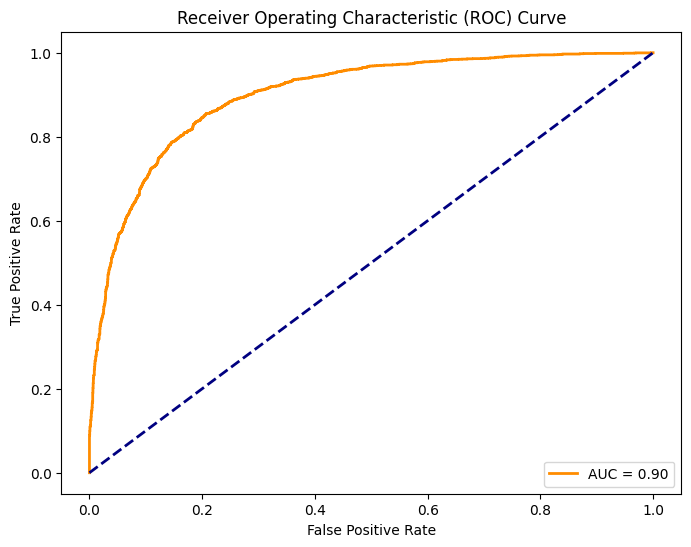

In [ ]:
# Assuming you have a test dataset named test_ds and labels for the test set named test_labels
# Replace test_ds and test_labels with your actual variables

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(val_ds)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Get model predictions on the test set
y_scores = model.predict(val_ds).ravel()

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(test_labels, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()
